# Impact analysis of child's environment on school performance in SAT.

## Introduction:

There is a known connection between school performance and the environment that a child is exposed to, including environmental conditions that may affect health, exposure to violence which affects stress level, and socioeconomic features, including income, which may determine the ability of a student to get help. Nonetheless, the modeling of school performance is difficult, as measures of performance may be biased and environmental features hard to measure.

In spite of that, in this notebook we attempt to model performance, measures through the SAT score, of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area, and optionally income.

The analysis is at the PUMA level. All data are accessible through NYC open data, the NY state open data portal (NY.gov).

The notebook is majorly divided into 2 parts:
### Part1: Data Gathering And Wrangling
### Part2: Visual and Exploratory Analysis and Modelling.

#### Import all the python packages that will be required in the notebook

In [1]:
# Import useful packages
from __future__  import print_function, division # python2.0 and python3.0
import pandas as pd # for handling data frames
import numpy as np # for handling numbers and arrays
import matplotlib.pylab as plt # for drwaing plots
import os # for running terminal commands
import urllib # for downloading data using url
from IPython.display import clear_output
plt.rcParams['font.size'] = 15
import geopandas as gpd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import pearsonr

try:
    from StringIO import BytesIO as io
except ImportError:
    from io import BytesIO as io

try:
    from urllib import urlencode as urlencode
except ImportError:
    from urllib.parse import urlencode as urlencode
    
try:
    from urllib import urlopen as urlopen
except ImportError:
    from urllib.request import urlopen as urlopen
    
try:
    from urllib2 import HTTPError as HTTPError
except ImportError:
    from urllib.error import HTTPError as HTTPError

import ast

%pylab inline 

Populating the interactive namespace from numpy and matplotlib


#### Define all function required in the notebook

In [2]:
# function for random forest feature importance
def featureImportancePlot(rf, labels):
    '''plots feature importance for random forest
    rf: the random forest model fit to the data
    labels: the names of the features
    '''
    
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)


    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(indices.shape[0]), rf.feature_importances_[indices],
       color="SteelBlue", yerr=std[indices], align="center")
    plt.xticks(range(indices.shape[0]), np.array(labels)[indices], rotation=90)
    plt.xlim([-1, indices.shape[0]])
    plt.show()

# Functions for SQL query
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

def queryCartoDB(query, formatting = 'CSV', source = SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    
    data = urlencode({'format': formatting, 'q': query}).encode("utf-8")
    try:
        response = urlopen(source, data)
        return response.read()
    except HTTPError as e:
        raise (ValueError('\n'.join(ast.literal_eval(e.readline())['error'])))
        
def get_data(query):
    '''Saves queries result as dataframe: 
    query - string: a valid sql query string
    Returns:
    the return of the sql query AS A DATAFRAME
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    try:
        return pd.read_csv(io(queryCartoDB(query)), sep = ',')
    except ValueError as v:
        print (str(v))

#### PUIdata: Required to store all the files that will be downloaded in the notebook

In [3]:
# Check if PUIDATA is present or not and if not set it up
if os.getenv("PUIDATA")==None:
    os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
    print("Earlier missing now, updated:  PUIdata:", os.getenv("PUIDATA"))
else:
    print("Already present: PUIdata", os.getenv("PUIDATA"))

Already present: PUIdata /nfshome/skp454/PUIdata


## PART 1: Data Gathering and Wrangling

### 1.1 Collect and process school SAT results of year 2012.

Data Source: NYC Open Data

Url : https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4

1. A new feature using all the SAT scores i.e. SAT Maths Score, SAT Reading Score and SAT writing SCore is generated.
2. This new feature is average of all features and is named as SATall. 

In [4]:
# Download SAT score 
df_sat = pd.read_csv("https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.cs\
v?accessType=DOWNLOAD")

# Check the dimension of data
print("The dimensions of SAT School data is:", df_sat.shape)

# Get a view of data
df_sat.head()

The dimensions of SAT School data is: (478, 6)


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [5]:
# Replace missing value with np.nan
df_sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score','SAT Writing A\
vg. Score']] = df_sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score'\
,'SAT Writing Avg. Score']].replace(to_replace = 's', value=np.nan)

# drop na's
df_sat.dropna(inplace=True)


# Convert score columns to integer
df_sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score','SAT Writing A\
vg. Score']] = df_sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Score'\
,'SAT Writing Avg. Score']].apply(lambda x: x.astype(float), axis=0)

# Create feature of total score:
df_sat['SATall'] = df_sat[['SAT Critical Reading Avg. Score', 'SAT Math Avg. Sc\
ore', 'SAT Writing Avg. Score']].mean(axis=1)

# Drop school name : not required
df_sat.drop(['SCHOOL NAME','Num of SAT Test Takers', 'SAT Critical Reading Avg.\
 Score', 'SAT Writing Avg. Score'], inplace= True, axis=1)

# Rename column names
df_sat.rename(columns={'SAT Math Avg. Score': 'SATmath'}, inplace =True)

# Check the dimension of data
print("The dimensions of SAT School data is:", df_sat.shape)

# View the data
df_sat.head()

The dimensions of SAT School data is: (421, 3)


,DBN,SATmath,SATall
0,01M292,404.0,374.000000
1,01M448,423.0,390.666667
2,01M450,402.0,383.000000
3,01M458,401.0,391.333333
4,01M509,433.0,402.333333


### 1.2 Collect and process School Crime Data

Data Source: NYC Open Data

URL: https://data.cityofnewyork.us/Education/2010-2016-School-Safety-Report/qybk-bjjc

In [6]:
# Download school crime data
df_crimes = pd.read_csv("https://data.cityofnewyork.us/api/views/qybk-bjjc/rows\
.csv?accessType=DOWNLOAD")

# Check the dimension of data
print("The dimensions of School Crime data is:", df_crimes.shape)

# Get a view of data
df_crimes.head(2) 

The dimensions of School Crime data is: (6310, 34)


,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [7]:
# subset safety report with only useful columns
df_crimes = df_crimes[['DBN', 'Major N', 'Oth N','NoCrim N', 'Prop N', 'Vio N',\
'AvgOfMajor N','AvgOfOth N', 'AvgOfNoCrim N', 'AvgOfProp N', 'AvgOfVio N','Lati\
tude', 'Longitude', '# Schools','School Year']]

# Drop NA's in field other than reporting crime statistics
df_crimes.dropna(subset=['DBN', 'Latitude', 'Longitude'], axis=0, inplace=True)

# Drop the duplicate rows in the dataframe
df_crimes.drop_duplicates(inplace=True)

# print the shape of df
print("The dimensions of crime data: ",df_crimes.shape)

# get the view of data
df_crimes.head()

The dimensions of crime data:  (5283, 15)


,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,# Schools,School Year
0,15K001,0.0,2.0,1.0,1.0,0.0,0.86,3.26,5.55,2.17,1.29,40.649042,-74.012289,1,2013-14
1,17K002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583,3,2013-14
2,75K141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583,3,2013-14
3,84K704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.656183,-73.951583,3,2013-14
5,13K003,2.0,0.0,0.0,2.0,0.0,0.33,1.32,1.76,0.83,0.59,40.682663,-73.955338,1,2013-14


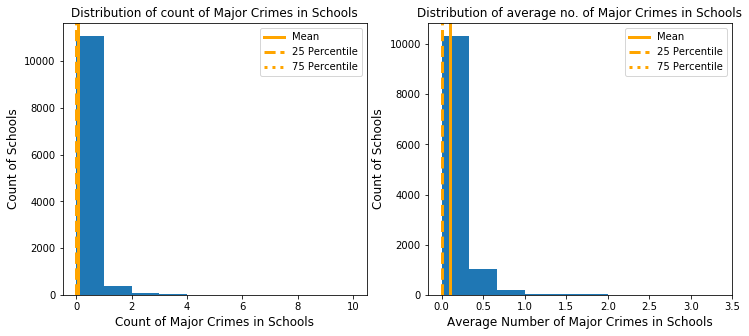

In [8]:
# plot the distributions

# define elements required for plot
plt.subplots(figsize=(12,5))
a = 1
plotSeries = pd.Series()

# run loop to make plots
for i in ['Major N', 'AvgOfMajor N']:
    
    # Many DBN contain multiple schools
    # Loop to include the given statistics multiple times  
    plotSeries = pd.Series()
    for j in df_crimes['# Schools'].unique():
        for k in range(j):
            plotSeries = pd.concat([plotSeries, df_crimes.loc[df_crimes['# Scho\
ols'] == j, i]])
    plotSeries.fillna(0, inplace=True)
    
    plt.subplot(1,2,a)
    plt.hist(plotSeries, bins=10)
    plt.ylabel("Count of Schools", fontsize=12)
    if i == 'Major N':
        plt.xlabel('Count of Major Crimes in Schools', fontsize=12)
        plt.title("Distribution of count of Major Crimes in Schools", fontsize=\
                  12)
    else:
        plt.xlabel('Average Number of Major Crimes in Schools', fontsize=12)
        plt.title("Distribution of average no. of Major Crimes in Schools",\
                  fontsize=12)
    
    plt.axvline(plotSeries.mean(), color = 'orange', linewidth=3.0, \
                label='Mean')
    plt.axvline(plotSeries.quantile(0.25), color = 'orange', linestyle='--', \
    linewidth=3.0, label = '25 Percentile')
    plt.axvline(plotSeries.quantile(0.75), color = 'orange', linestyle=':', \
    linewidth=3.0, label = '75 Percentile')
    a = a+1
    plt.legend()


**Figure : Distribution plot of Major Crimes and Average Major Crimes in Schools**
1. In the above plot the left distribution shows the distribution of major crimes in schools and the right distribution shows the average of major crimes in schools.
2. In the left distribution, both 25 percentile and 75 percentile line lies at zero showing number of major crimes in most of the school is 0 and in only few schools it is more than 0.
3. In the right distribution the mean line at 0.2 shows the average number of major crimes in schools is about ~0.2.

### 2.1 Merge the SAT and the crime in school data based on the school identifier. 

Since, DBN is present in both datasets: School SAT score and School safety report, we will use DBN as key for merge.

In [9]:
# merge on DBN: Common in both dataframes
df_schools = df_sat.merge(df_crimes, on='DBN', how='inner')

# print the shape of df
print("The dimensions of combined school data: ",df_schools.shape)

# get the view of data
df_schools.head()

The dimensions of combined school data:  (1197, 17)


,DBN,SATmath,SATall,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,# Schools,School Year
0,01M292,404.0,374.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.713684,-73.986336,4,2013-14
1,01M292,404.0,374.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.713684,-73.986336,4,2014-15
2,01M292,404.0,374.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.713684,-73.986336,4,2015-16
3,01M448,423.0,390.666667,1.0,0.0,2.0,1.0,0.0,0.35,1.06,1.09,0.73,0.50,40.712399,-73.984497,1,2013-14
4,01M448,423.0,390.666667,0.0,1.0,2.0,1.0,0.0,0.27,1.11,1.38,0.80,0.48,40.712399,-73.984497,1,2014-15


### 2.2 Fill in the missing data as appropriate

In [10]:
# Check the missing data
df_schools.isnull().sum()

DBN                0
SATmath            0
SATall             0
Major N          849
Oth N            849
NoCrim N         849
Prop N           849
Vio N            849
AvgOfMajor N     849
AvgOfOth N       849
AvgOfNoCrim N    849
AvgOfProp N      849
AvgOfVio N       849
Latitude           0
Longitude          0
# Schools          0
School Year        0
dtype: int64

**It appears that only crime statistics have missing data. Since, schools where no crime has taken place have missing data, we will impute 0 for them.** 

In [11]:
# Impute 0 for missing data in crime statistics
df_schools.fillna(0, inplace=True)

**It is also possible that 0 or any other number is used in place of missing data in SAT scores so, we will check the distribution of these features and through number for minimum we will ensure no faulty data point is present in our dataset.** 

In [12]:
# No missing data in SAT scores, check distribution to see if 0 is present
print("The minimum of both the features shows there is no missing data which is\
 masked as 0 from before.")
df_schools[['SATmath','SATall']].describe()

The minimum of both the features shows there is no missing data which is masked as 0 from before.


,SATmath,SATall
count,1197.000000,1197.000000
mean,415.677527,404.463659
std,65.467917,59.034878
min,312.000000,295.666667
25%,373.000000,368.333333
50%,398.000000,391.333333
75%,440.000000,421.666667
max,735.000000,698.666667


### 2.3 Count the individual school location:

In [13]:
# Duplicate DBN in sat score dataframe
print("Number of duplicate DBN in SAT Score:", len(df_sat)-len(df_sat['DBN'].un\
ique()))

Number of duplicate DBN in SAT Score: 0


**The number of duplicates DBN in SAT Score data is zero.**

**But in crimes data as multiple schools are present in a DBN. 
Hence, for a given DBN and School year there are duplicate entries.
These duplicate data points will act as noise in our data thus, affecting the models we make and analysis we do.
We will aggregate the data on unique identifiers taking sum of Number of crimes, and average of average statistics of crime and SAT scores.**

In [14]:
# group by unique identifiers
df_schools = pd.DataFrame(df_schools.groupby(['DBN','Latitude', 'Longitude', 'S\
chool Year'], as_index=False).agg({'SATmath': 'mean', 'SATall': 'mean', 'Major \
N': 'sum', 'Oth N': 'sum', 'NoCrim N': 'sum', 'Prop N': 'sum','Vio N': 'sum', '\
AvgOfMajor N': 'mean', 'AvgOfOth N': 'mean', 'AvgOfNoCrim N': 'mean', 'AvgOfPro\
p N': 'mean', 'AvgOfVio N': 'mean'}))

# drop school year as it is not required for further analysis
df_schools.drop(['School Year'], inplace=True, axis=1)

# drop duplicates data if still present
df_schools.drop_duplicates(inplace=True)

# reset index
df_schools.reset_index(inplace=True, drop=True)

# print the shape of df
print("The dimensions of final combined school data: ",df_schools.shape)

# get the view of data
df_schools.head()

The dimensions of final combined school data:  (648, 15)


,DBN,Latitude,Longitude,AvgOfOth N,AvgOfVio N,SATall,Prop N,SATmath,AvgOfNoCrim N,AvgOfProp N,Major N,AvgOfMajor N,Oth N,NoCrim N,Vio N
0,01M292,40.713684,-73.986336,0.00,0.00,374.000000,0.0,404.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0
1,01M448,40.712399,-73.984497,1.06,0.50,390.666667,1.0,423.0,1.09,0.73,1.0,0.35,0.0,2.0,0.0
2,01M448,40.712399,-73.984497,1.11,0.48,390.666667,1.0,423.0,1.38,0.80,0.0,0.27,1.0,2.0,0.0
3,01M448,40.712399,-73.984497,0.90,0.44,390.666667,0.0,423.0,1.67,0.63,0.0,0.27,3.0,5.0,1.0
4,01M450,40.729589,-73.982555,1.32,0.59,383.000000,3.0,402.0,1.76,0.83,1.0,0.33,4.0,0.0,1.0


**The final number of data points left after cleaning the data is 648.
In this process of cleaning we have reduced 549 (1197 - 648) data points which were duplicates.**

### 3.1 Plot the Math SAT score and the average of all SAT scores as a function of two crime statistics.

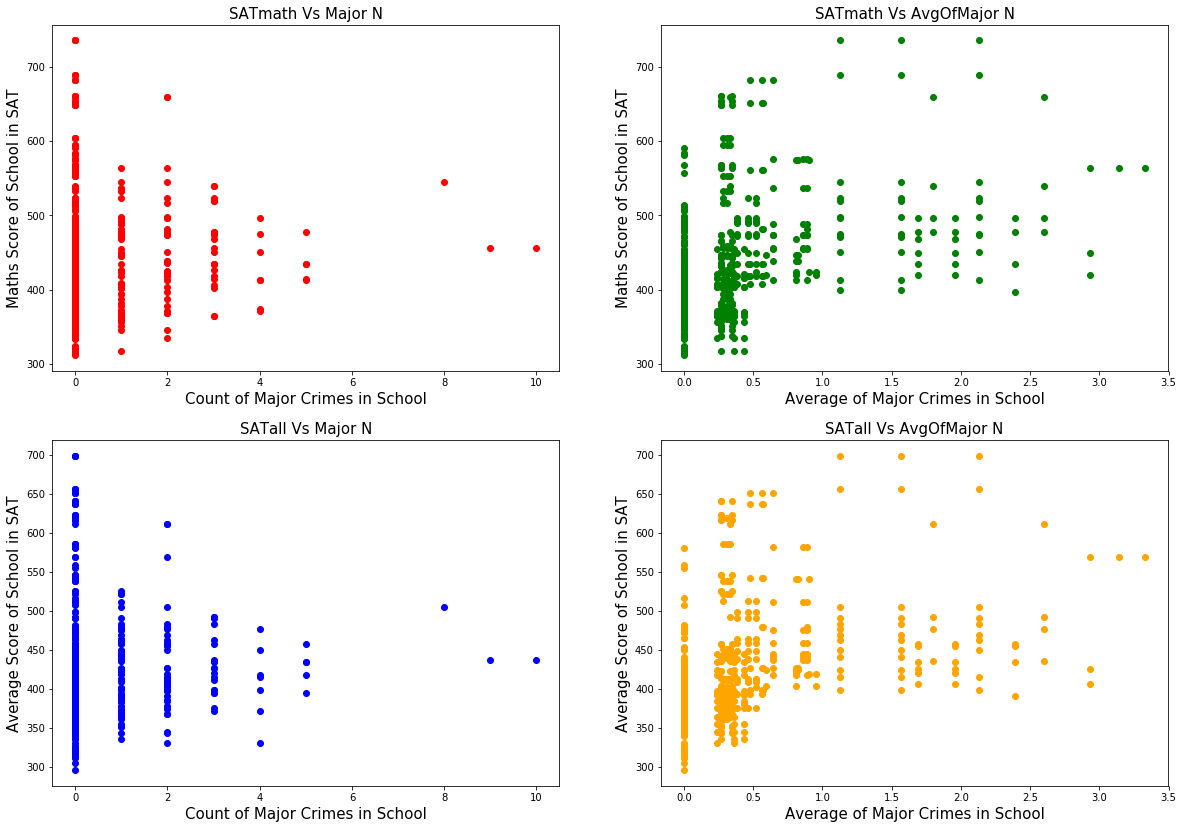

In [15]:
# Plot the scatter plots
plt.subplots(figsize=(20,14))

a = 1
colors = ['', 'red', 'green', 'blue', 'orange']
for i in ['SATmath','SATall']:
    for j in ['Major N','AvgOfMajor N']:
        plt.subplot(2,2,a)
        plt.plot(df_schools[j], df_schools[i], '.', marker='o', color=colors[a])
        a = a + 1
        if j == 'Major N':
            plt.xlabel('Count of Major Crimes in School', fontsize=15 )
        else:
            plt.xlabel('Average of Major Crimes in School', fontsize=15 )
        
        if i == 'SATmath':
            plt.ylabel('Maths Score of School in SAT', fontsize=15 )
        else:
            plt.ylabel('Average Score of School in SAT', fontsize=15 )
        
        plt.title(i + ' Vs ' + j, fontsize=15)

**Figure: Plot of school's SAT math score and SAT overall average score as function of crime statistics.**
1. The above 4 plots shows school's SAT math and SAT avg. vs number of major crimes and avg. number of major crimes in schools.
2. As we can see in the above plots, as number of major crimes is increasing the range of SAT scores is decreasing with fairly same mean.
3. The above plots show a non-linear relationship between SAT scores and Major crimes.
4. As number of average major crimes increases the SAT scores are fairly above 400. A linear relationship is still tough here.
5. The distribution of both SAT scores across both crime statistics are almost similar signaling high collinearity between variables.

### 3.2 Create geometry from the lat-lon coordinates and map the location of each school in the dataset

In [16]:
# Create geometry
geometry = [Point(xy) for xy in zip(df_schools.Longitude, df_schools.Latitude)]

# initiate crs for geodataframe
crs = {'init': 'epsg:4326'}

# convert to Geodataframe
gdf_schools = gpd.GeoDataFrame(df_schools, crs=crs, geometry=geometry)

# drop lat and lon features
gdf_schools.drop(['Longitude', 'Latitude'], axis=1, inplace=True)

# take a view of data
gdf_schools.head()

,DBN,AvgOfOth N,AvgOfVio N,SATall,Prop N,SATmath,AvgOfNoCrim N,AvgOfProp N,Major N,AvgOfMajor N,Oth N,NoCrim N,Vio N,geometry
0,01M292,0.00,0.00,374.000000,0.0,404.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,POINT (-73.98633599999999 40.713684)
1,01M448,1.06,0.50,390.666667,1.0,423.0,1.09,0.73,1.0,0.35,0.0,2.0,0.0,POINT (-73.98449699999999 40.712399)
2,01M448,1.11,0.48,390.666667,1.0,423.0,1.38,0.80,0.0,0.27,1.0,2.0,0.0,POINT (-73.98449699999999 40.712399)
3,01M448,0.90,0.44,390.666667,0.0,423.0,1.67,0.63,0.0,0.27,3.0,5.0,1.0,POINT (-73.98449699999999 40.712399)
4,01M450,1.32,0.59,383.000000,3.0,402.0,1.76,0.83,1.0,0.33,4.0,0.0,1.0,POINT (-73.982555 40.729589)


**Download the shapefile for NYC, store it in PUIdata and then read it in the notebook.**

Data Source: CornellUniversity Geospatial Information Repository

URL: https://cugir.library.cornell.edu/catalog/cugir-007865

In [17]:
# Download shapefile for using URL and move to PUI folder
url = "https://s3.amazonaws.com/cugir-data/00/78/65/cugir-007865.zip"
urllib.request.urlretrieve(url, "nycskp.zip")

os.system("mv nycskp.zip " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/nycskp.zip -d nycskp/")
os.system("mv nycskp " + os.getenv("PUIDATA"))

256

In [18]:
# Read NYC shapefile
gdf_nyc = gpd.read_file(os.getenv("PUIDATA")+'/nycskp/cugir-007865/cty036.shp')
gdf_nyc.crs = {'init' :'epsg:4326'}

# Subset data relevant for NYC
gdf_nyc['NYC'] = gdf_nyc['NAME'].apply(lambda x: x in ['Bronx', 'New York', 'Qu\
eens', 'Kings', 'Richmond'] )
gdf_nyc = gdf_nyc[gdf_nyc['NYC']==True]

Text(0.5,1,' Locations of Schools in New York City')

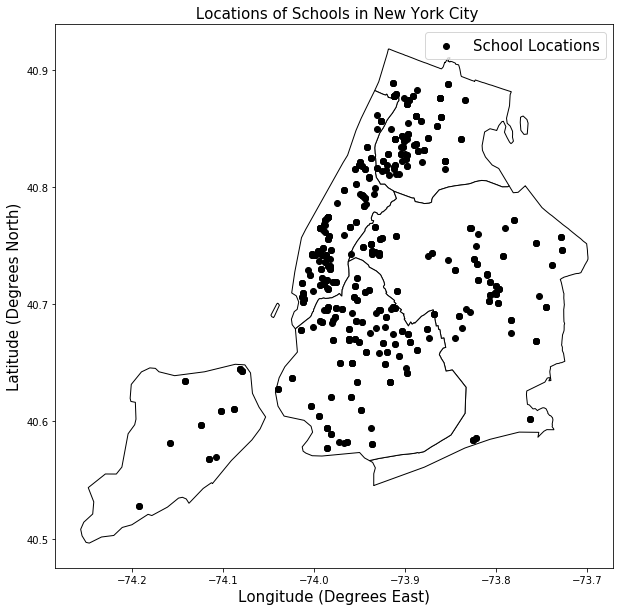

In [19]:
# plot locations of schools in NYC
fig, ax = plt.subplots(figsize=(10,10))
gdf_nyc.plot(ax= ax, edgecolor ='black', color='white')
gdf_schools.plot(ax= ax, color='black', label='School Locations')
plt.legend(fontsize = 15)
plt.xlabel('Longitude (Degrees East)', fontsize = 15)
plt.ylabel('Latitude (Degrees North)', fontsize = 15)
plt.title(' Locations of Schools in New York City', fontsize = 15)


**Figure: Locations of Schools in New York City**
1. The above plot shows locations of all the schools we have in our data for Crime and SAT Score.
2. As we can see in the plot the schools are distributed across the whole city.

### 4.1 Read in the SPARCS data

For getting the data related to living condition we will use the Statewide Planning and Research Cooperative System(SPARCS) data set from Health Data NY.

Url: https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/u4ud-w55t

In [ ]:
# Download sparcs data and store in PUIdata
os.system("curl https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD > sparcs.csv")
os.system("mv sparcs.csv " + os.getenv("PUIDATA"))

In [20]:
# Read the sparcs data
df_sparcs = pd.read_csv(os.getenv("PUIDATA")+'/sparcs.csv')

# mark all nyc counties
df_sparcs['P'] = df_sparcs['Hospital County'].apply(lambda x: x in ['Bronx','Ki\
ngs', 'Manhattan', 'Queens', 'Richmond'])

# subset nyc counties
df_sparcs= df_sparcs.loc[df_sparcs['P']==True,:]

# drop the marker column
df_sparcs.drop('P', inplace=True, axis=1)

In [21]:
# print the shape of df
print("The dimensions of final sparcs data: ",df_sparcs.shape)

# get the view of data
df_sparcs.head()

The dimensions of final sparcs data:  (1199520, 37)


,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35
954762,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,...,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53
954951,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,...,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92
954967,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,...,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90


### 4.2 calculate the fraction of asthma and drug related diagnoses per facility

1. For the incidence of respiratory related issues we will generate a feature 'asthmaRatio'. This feature will be the ratio of asthma related discharge with the total discharge of any give hospital facility.
2. We will categorize issues such as 'Asthma', 'Respiratory failure; insufficiency; arrest (adult)' and 'Respiratory distress syndrome' under asthma related issues.
3. For the incidence of drugs related issues we will generate a feature 'drugsRatio'. This feature will be the ratio of drugs related discharge with the total discharge of any give hospital facility.
4. We will categorize issues such as 'Poisoning by psychotropic agents', 'Substance-related disorders', 'Alcohol-related disorders' under drugs related issues.

In [22]:
# keep useful columns
df_sparcs = df_sparcs[['Facility ID','CCS Diagnosis Description']]

# Find asthma and drug related issues
df_sparcs['asthma'] = df_sparcs['CCS Diagnosis Description'].apply(lambda x: x \
in ['Asthma', 'Respiratory failure; insufficiency; arrest (adult)', 'Respirator\
y distress syndrome'])
df_sparcs['drugs'] = df_sparcs['CCS Diagnosis Description'].apply(lambda x: x i\
n ['Poisoning by psychotropic agents', 'Substance-related disorders', 'Alcohol-\
related disorders'])

# Number of discharge
print('number of NYC discharges', len(df_sparcs))

# Number of Unique facilities 
print("number of NYC facilities in the dataset", len(df_sparcs['Facility ID'].u\
nique()))

# Number of asthma cases
print("number of asthma related cases in NYC", df_sparcs['asthma'].sum()) 

# Number of Drugs cases
print("number of drug related cases in NYC", df_sparcs['drugs'].sum())

number of NYC discharges 1199520
number of NYC facilities in the dataset 61
number of asthma related cases in NYC 30717
number of drug related cases in NYC 46336


In [23]:
# groupby to create df_discharge
df_discharge = pd.DataFrame(df_sparcs.groupby(['Facility ID'], as_index = False\
).agg({'asthma' : 'sum', 'drugs' : 'sum', 'CCS Diagnosis Description' : 'count'}))

# calculate asthma ratio
df_discharge['asthmaRatio'] = df_discharge['asthma']/df_discharge['CCS Diagnosi\
s Description']

# calculate drugs ratio
df_discharge['drugsRatio'] = df_discharge['drugs']/df_discharge['CCS Diagnosis \
Description']

# drop uneccesary columns
df_discharge.drop(['drugs', 'CCS Diagnosis Description', 'asthma'], axis=1, inp\
lace=True)

# drop rows where asthmaRatio or drugsRatio < 1
df_discharge = df_discharge[(df_discharge['asthmaRatio']>0) & (df_discharge['dr\
ugsRatio']>0)]

# print the shape of df
print("The dimensions of discharge data: ",df_discharge.shape)

# get the view of data
df_discharge.head()

The dimensions of discharge data:  (52, 3)


,Facility ID,asthmaRatio,drugsRatio
1,1165.0,0.053588,0.061033
2,1168.0,0.036503,0.063314
3,1169.0,0.048225,0.007400
4,1172.0,0.078904,0.026402
6,1176.0,0.044207,0.202915


**We lost data of 9 (61-52) facilities as we didn't had either asthma or drugs related discharge in them.**

### 4.3 find the location of each facility

The location of these health facilities can be found at Dr. Fedrica Bianco's carto account and can be accessed with a SQL query.

SQL Source URL:  "https://fb55.carto.com:443/api/v2/sql?q="

In [24]:
# Write SQL query to get lat lon of facility
query = '''SELECT facility_id, facility_latitude, facility_longitude
            FROM nyc_facilities; '''

# Run Sql query and store result in dataframe
df_facility = get_data(query)

# print the shape of df
print("The dimensions of facility data: ",df_facility.shape)

# get the view of data
df_facility.head()

The dimensions of facility data:  (1275, 3)


,facility_id,facility_latitude,facility_longitude
0,1320,40.654518,-73.945045
1,6448,40.653175,-73.886772
2,6754,40.689243,-73.956383
3,1206,40.846165,-73.904655
4,1207,40.814503,-73.919029


In [25]:
# merge discharge data with facility lat lon
df_dischargeFinal = df_discharge.merge(df_facility, left_on = 'Facility ID', ri\
ght_on ='facility_id', how = 'inner')

# drop uneccesary columns
df_dischargeFinal.drop(['facility_id'], axis=1, inplace=True)

# print the shape of df
print("The dimensions of final discharge data: ",df_dischargeFinal.shape)

# get the view of data
df_dischargeFinal.head()

The dimensions of final discharge data:  (49, 5)


,Facility ID,asthmaRatio,drugsRatio,facility_latitude,facility_longitude
0,1165.0,0.053588,0.061033,40.857388,-73.846741
1,1168.0,0.036503,0.063314,40.894569,-73.861420
2,1169.0,0.048225,0.007400,40.879951,-73.880562
3,1172.0,0.078904,0.026402,40.817661,-73.924210
4,1176.0,0.044207,0.202915,40.853909,-73.891014


**After merging the lat & lon of facility with discharge data, we lost 3(52 - 49) data for 3 facilities.** 

In [26]:
# Create geometry
geometry = [Point(xy) for xy in zip(df_dischargeFinal.facility_longitude, df_di\
schargeFinal.facility_latitude)]

# initiate crs for geodataframe
crs = {'init': 'epsg:4326'}

# convert discharge data to Geodataframe
gdf_discharge = gpd.GeoDataFrame(df_dischargeFinal, crs=crs, geometry=geometry)

# drop lat and lon features
gdf_discharge.drop(['facility_latitude', 'facility_longitude'], axis=1, inplace\
=True)

# take a view of data
gdf_discharge.head()

,Facility ID,asthmaRatio,drugsRatio,geometry
0,1165.0,0.053588,0.061033,POINT (-73.84674100000001 40.857388)
1,1168.0,0.036503,0.063314,POINT (-73.86142 40.894569)
2,1169.0,0.048225,0.007400,POINT (-73.880562 40.879951)
3,1172.0,0.078904,0.026402,POINT (-73.92421 40.817661)
4,1176.0,0.044207,0.202915,POINT (-73.891014 40.853909)


### 5.1 Getting PUMA geodata

We will use the Public Use Microdata Areas to aggregate the SAT score, crime and health statistics and do further analysis.

The Public Use Microdata Areas geodata is available from NYC open data.

URL: https://data.cityofnewyork.us/Housing-Development/Public-Use-Microdata-Areas-PUMA-/cwiz-gcty

In [27]:
# Download shapefile using URL and move to PUI folder
url = "https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&for\
mat=Shapefile"
urllib.request.urlretrieve(url, "puma.zip")

os.system("mv puma.zip " + os.getenv("PUIDATA"))
os.system("unzip " + os.getenv("PUIDATA") + "/puma.zip -d puma/")
os.system("mv puma " + os.getenv("PUIDATA"))

# Find the name of shapefile
for filename in os.listdir(os.getenv("PUIDATA")+"/puma/"):
    if 'shp' in filename:
        shp_file = filename

# Read shapefile using geopandas
gdf_pumashp = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA")+"/puma/"+shp_file)

# Print crs of puma shp
print('The crs of puma shape is: ', gdf_pumashp.crs)

# print the shape of df
print("The dimensions of puma data: ",gdf_pumashp.shape)

The crs of puma shape is:  {'init': 'epsg:4326'}
The dimensions of puma data:  (55, 4)


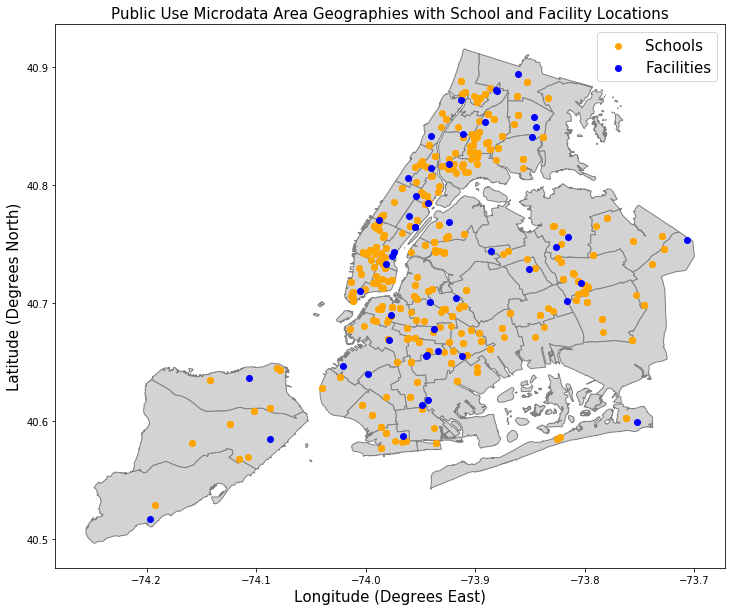

In [28]:
# Plot puma with school and facilities location
fig, ax = plt.subplots(1, figsize= (12, 10))

# plot puma
gdf_pumashp.plot(ax = ax, color = 'lightgrey', edgecolor = 'grey')

# plot school locations
gdf_schools.plot(ax = ax, color = 'orange', marker = 'o', label = 'Schools')

# plot facilities location
gdf_discharge.plot(ax = ax, color = 'blue', marker = 'o', label = 'Facilities')

# plot attributes
plt.legend(fontsize = 15)
plt.title("Public Use Microdata Area Geographies with School and Facility Locat\
ions", fontsize = 15)
plt.xlabel('Longitude (Degrees East)', fontsize = 15)
plt.ylabel('Latitude (Degrees North)', fontsize = 15)
plt.show()

**Figure: Choropleth showing locations of schools and hospital facilities across different PUMA's of NYC**
1. The above figure shows different polygons of PUMA's in NYC and the orange and blue dots shows locations of schools and hospital facilities respectively.
2. The schools and hospitals are fairly distributed across PUMA's and are not concentrated in specific regions.
3. Few PUMA's does not have either hospital facilities or schools or both. Thus, we will loose some PUMA's when we join all the data.

**Now, we will separately spatially join the schools data and discharge data with PUMA geodata and calculate the mean of each feature by PUMA.**

In [29]:
# Spatial join school data with puma sahpes and average on puma
df_schoolsPuma = gpd.sjoin(gdf_schools, gdf_pumashp, how = "inner", op = "inter\
sects").groupby(['puma'], as_index = False).mean()

# drop unnecessary columns
df_schoolsPuma.drop(['index_right', 'shape_area', 'shape_leng'], axis=1, inplac\
e=True)

# Spatial join discharge data with puma sahpes and average on puma
df_dischargePuma = gpd.sjoin(gdf_discharge, gdf_pumashp, how = "inner", op = "i\
ntersects").groupby(['puma'], as_index = False).mean()

# drop unnecessary columns
df_dischargePuma.drop(['Facility ID', 'index_right', 'shape_area', 'shape_leng'\
], axis=1, inplace=True)

In [30]:
# print the shape of df
print("The dimensions of schools and PUMA join data: ",df_schoolsPuma.shape)

# get the view of data
df_schoolsPuma.head()

The dimensions of schools and PUMA join data:  (53, 13)


,puma,AvgOfOth N,AvgOfVio N,SATall,Prop N,SATmath,AvgOfNoCrim N,AvgOfProp N,Major N,AvgOfMajor N,Oth N,NoCrim N,Vio N
0,3701,2.295263,0.945263,473.824561,0.789474,488.157895,3.897895,1.413684,0.052632,0.501579,1.421053,2.947368,0.263158
1,3702,0.000000,0.000000,374.740741,0.000000,378.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3703,0.000000,0.000000,391.400000,0.000000,394.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3704,0.416250,0.188750,409.125000,1.375000,417.750000,0.601250,0.282500,0.000000,0.108750,2.625000,1.625000,1.000000
4,3705,0.461081,0.212162,372.558559,0.945946,377.567568,0.685135,0.311351,0.405405,0.123243,2.162162,3.540541,1.054054


** We will loose 2 PUMAs as there is no school present in them **

In [31]:
# print the shape of df
print("The dimensions of discharge and PUMA join data: ",df_dischargePuma.shape)

# get the view of data
df_dischargePuma.head()

The dimensions of discharge and PUMA join data:  (37, 3)


,puma,asthmaRatio,drugsRatio
0,3702,0.036503,0.063314
1,3704,0.037053,0.032269
2,3705,0.044207,0.202915
3,3706,0.038256,0.013680
4,3707,0.054454,0.013583


** We will loose 18 PUMAs as there is no discharge facility present in them **

### 5.2 Merge hospital facilities and PUMA data

In [32]:
# merge puma shape with puma avg. discharge features
gdf_alldata = gdf_pumashp.merge(df_dischargePuma, on='puma', how='inner')

# print the shape of df
print("The dimensions of all data: ",gdf_alldata.shape)

# get the view of data
gdf_alldata.head()

The dimensions of all data:  (37, 6)


,puma,shape_area,shape_leng,geometry,asthmaRatio,drugsRatio
0,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",0.036503,0.063314
1,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.037053,0.032269
2,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,0.029730,0.007400
3,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,0.044207,0.202915
4,3706,4.388687e+07,51799.404183,"POLYGON ((-73.88785196328796 40.8721141761279,...",0.038256,0.013680


** We lost 18 PUMAs as there is no discharge facility present in them **

### 5.3 Merge school data and puma

In [33]:
# merge puma shape with puma avg. discharge features
gdf_alldata = gdf_alldata.merge(df_schoolsPuma, on='puma', how='inner')

# print the shape of df
print("The dimensions of all data: ",gdf_alldata.shape)

# get the view of data
gdf_alldata.head()

The dimensions of all data:  (36, 18)


,puma,shape_area,shape_leng,geometry,asthmaRatio,drugsRatio,AvgOfOth N,AvgOfVio N,SATall,Prop N,SATmath,AvgOfNoCrim N,AvgOfProp N,Major N,AvgOfMajor N,Oth N,NoCrim N,Vio N
0,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",0.036503,0.063314,0.000000,0.000000,374.740741,0.000000,378.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",0.037053,0.032269,0.416250,0.188750,409.125000,1.375000,417.750000,0.601250,0.282500,0.000000,0.108750,2.625000,1.625000,1.000000
2,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,0.029730,0.007400,4.492857,1.757143,479.809524,2.142857,500.000000,7.827143,2.720000,1.000000,0.920000,5.571429,9.857143,3.142857
3,3705,1.224951e+08,68657.316149,POLYGON ((-73.87359713633828 40.83979855593596...,0.044207,0.202915,0.461081,0.212162,372.558559,0.945946,377.567568,0.685135,0.311351,0.405405,0.123243,2.162162,3.540541,1.054054
4,3707,4.228113e+07,37347.925798,"POLYGON ((-73.89735765412577 40.8587627349268,...",0.054454,0.013583,0.000000,0.000000,356.833333,0.000000,365.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


** We lost 1 PUMA as there is discharge facility but no school present in it.**

** Ovearll we lost 19 PUMA's in merge and are left with 36 PUMA's which have both schools and discharge facilities.**

## PART II: Visual and Exploratory analysis and Modeling

### 6.1 Plot SAT features against each other and assess collinearity (4 points)

1. Here, first we will visualize the variables and try to fit a line between them.
2. Then we will use a correlation test to validate if correlation is actually present or not.

                            OLS Regression Results                            
Dep. Variable:                 SATall   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 2.881e+04
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           1.25e-52
Time:                        21:17:58   Log-Likelihood:                -147.47
No. Observations:                  36   AIC:                             296.9
Df Residuals:                      35   BIC:                             298.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
SATmath        0.9674      0.006    169.731      0.0

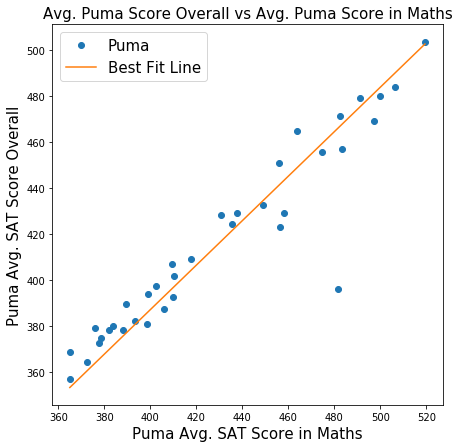

In [34]:
# Define a best fit model
mod = sm.OLS(gdf_alldata['SATall'], gdf_alldata['SATmath']).fit()

# print the summary
print(mod.summary())

# plot overall score vs math score with best fit line.
plt.subplots(figsize=(7,7))

# plot SATmath vs SATall
plt.plot(gdf_alldata['SATmath'], gdf_alldata['SATall'],'.', marker ='o', label \
= 'Puma')

# plot best fit line
plt.plot(gdf_alldata['SATmath'].sort_values(), mod.predict(gdf_alldata['SATmath\
'].sort_values()), label='Best Fit Line')

# plot attributes
plt.xlabel('Puma Avg. SAT Score in Maths', fontsize=15)
plt.ylabel('Puma Avg. SAT Score Overall', fontsize=15)
plt.title('Avg. Puma Score Overall vs Avg. Puma Score in Maths', fontsize=15)
plt.legend(fontsize=15)

**Model and Figure: Puma avg. overall score in SAT vs puma avg. math score in SAT**
1. The above plot shows the puma avg. score in SAT overall compared against puma avg. score in math with a best fit line obtained from the model above.
2. From the plot we can see there is a high linear collinearitry between both the variables.
3. The collinearity is further supported by the best fit line and model which is able to expalin 99% variation(R-Square) in overall score using the math score.
4. the coefficient of 0.9674 without intercept shows that the correlation between the variable is very strong.

**Correlation Test**

To test the correlation between SAT math score and SAT overall average score we will use pearsonr correlation test.
Using the pearsonr we will test the hypothesis:

**H0: SAT maths score is not significantly correlated to SAT overall average score and a line of slope 0 lies within the significant confidence interval.**

**H1: SAT maths score is correlated to SAT overall average and the line of slope 0 betwen these 2 features does not lie within the significant confidence intervel.**

**Significant p-value threshold(alpha) = 0.05**

In [35]:
results = pearsonr(gdf_alldata['SATmath'], gdf_alldata['SATall'])

print(" The correlation coefficient between given variables is: ", results[0])
print(" The p-value for correlation coefficient between given variables is: ", results[1])

 The correlation coefficient between given variables is:  0.944834357675
 The p-value for correlation coefficient between given variables is:  4.73789496604e-18


**The correlation coefficient of 0.999 shows high correlation between the 2 variables.**

**The p-value for coefficient is significantly lower than our threshold 0.05 thus, we reject the Null hypothesis that the 2 varaibles: SAT math scores and SAT overall average scores are not correlated with each other and accept the alternate hypothesis that they are indeed correlated with each other.**

### 6.2 Plot the SAT features by PUMA against 3 of the crime features (3 points)

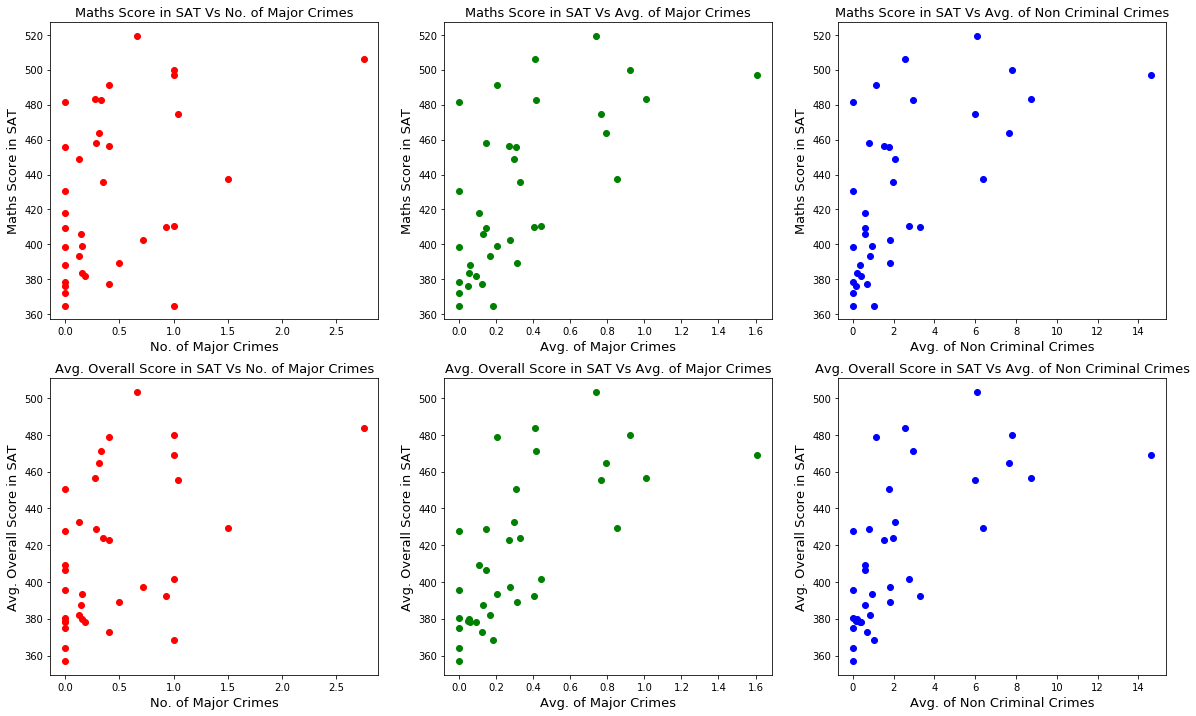

In [36]:
# Plot the scatter plots
plt.subplots(figsize=(20,12))

# plot requisites
xlist = ['Major N','AvgOfMajor N', 'AvgOfNoCrim N']
ylist = ['SATmath','SATall']
colors = ['', 'red', 'green', 'blue', 'red', 'green', 'blue']
xlabel = ['No. of Major Crimes','Avg. of Major Crimes', 'Avg. of Non Criminal C\
rimes']
ylabel = ['Maths Score in SAT', 'Avg. Overall Score in SAT']
a = 1

# Run nested loop to plot the SAT features against crime features
for i in ylist:
    for j in xlist:
        # make plot
        plt.subplot(2,3,a)
        plt.plot(gdf_alldata[j], gdf_alldata[i], '.', marker='o', color=colors[\
a])
        
        # plot attributes
        a = a + 1
        plt.xlabel(xlabel[xlist.index(j)], fontsize=13)
        plt.ylabel(ylabel[ylist.index(i)], fontsize=13)
        
        plt.title(ylabel[ylist.index(i)] + ' Vs ' + xlabel[xlist.index(j)], fon\
tsize=13)

**All the numbers in the above plot are PUMA level average of schools parameters in the particular feature**

**Figure: Plots to show relations of PUMA's average SAT scores in schools with PUMA's average crime statistics in schools.**
1. The above plots show relations of PUMA's average SAT scores in schools( Maths score and overall average) with PUMA's average crime statistics in schools ( Number of Major Crimes, Average number of Major Crimes and Average Number of Non-criminal crimes).
2. As we can see in left 2 columns of plot we have a weak linear relation where the scores increases with increase in crime statistics(Avg. Major Crimes and avg. Non-Criminal Crimes).
3. It is hard to describe relation of SAT scores and Number of major crimes.


### 6.3 Plot the SAT features against medical data (3 points)


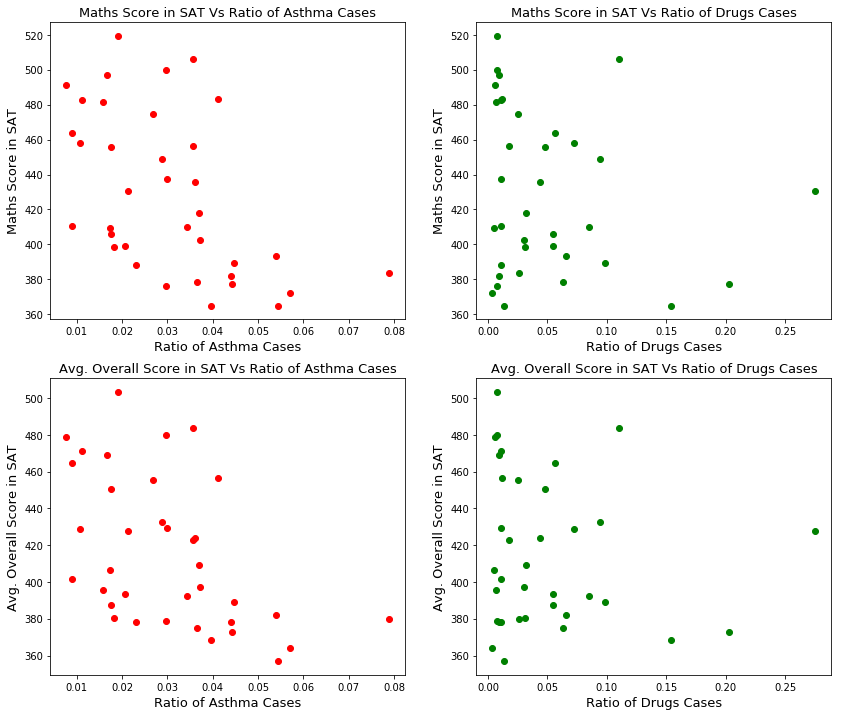

In [37]:
# Plot the scatter plots
plt.subplots(figsize=(14,12))

# plot requisites
xlist = ['asthmaRatio','drugsRatio']
ylist = ['SATmath','SATall']
colors = ['', 'red', 'green', 'red', 'green']
xlabel = ['Ratio of Asthma Cases','Ratio of Drugs Cases']
ylabel = ['Maths Score in SAT', 'Avg. Overall Score in SAT']
a = 1

# run nested loop to make plots
for i in ylist:
    for j in xlist:
        
        # make plots
        plt.subplot(2,2,a)
        plt.plot(gdf_alldata[j], gdf_alldata[i], '.', marker='o', color=colors[\
a])
        
        # plot attributes
        a = a + 1
        plt.xlabel(xlabel[xlist.index(j)], fontsize=13)
        plt.ylabel(ylabel[ylist.index(i)], fontsize=13)
        
        plt.title(ylabel[ylist.index(i)] + ' Vs ' + xlabel[xlist.index(j)], fon\
tsize=13)

**All the numbers in the above plot are Puma level average of schools parameters in the particular feature**

**Figure: Plots to show relations of PUMA's average SAT scores in schools with PUMA's average asthma and drugs ratio.**
1. The above plots show relations of PUMA's average SAT scores ( Maths score and overall average) in schools with PUMA's average discharge statistics( ratio of asthma related discharge and ratio of drugs related discharge).
2. As we can see in left column of plot we have a weak negative linear relation where the scores decreases with increase in asthma ratio statistics.
3. It is hard to describe relation of SAT scores and drug ratio.


### 6.4 Plot covariance of all the features

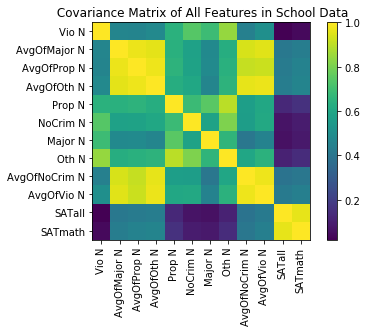

In [38]:
# list of all features in final data
lis_features = [ 'Vio N', 'AvgOfMajor N', 'AvgOfPro\
p N', 'AvgOfOth N','Prop N', 'NoCrim N', 'Major N', 'Oth N', 'AvgOfNoCrim N','A\
vgOfVio N', 'SATall','SATmath']

# find correlation of fetaures with each other
arr_schoolcorr = gdf_alldata[lis_features].corr()
arr_schoolcorr = df_schools[lis_features].corr()

# make the plot
ax = plt.figure().add_subplot(111)
cax = ax.imshow(arr_schoolcorr)

# plot attributes
plt.colorbar(cax)
plt.title(" Covariance Matrix of All Features in School Data")
ax.set_xticks(range(len(lis_features)))
ax.set_xticklabels(lis_features, rotation=90)
ax.set_yticks(range(len(lis_features)))
ax.set_yticklabels(lis_features);

**Figure: Covariance matrix of all features in School dataset**

1. The above plot shows the covariance of all statistics in school data, each cell represents the correlation between the variables reflected by its row position and column positions.
2. As can be seen in the above plot, avg. of crime statistics have very strong correlation amongst them. Thus, for modelling only few of the relevant features amongst these should be used.
3. SAT scores and avg. crime statistics have positive yet weak correlations.

### 7.1 Map choropleths of all fetaures 

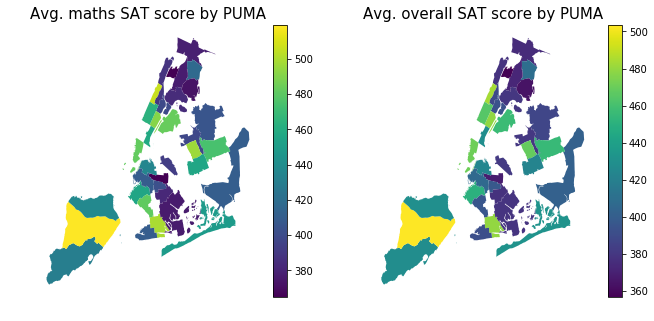

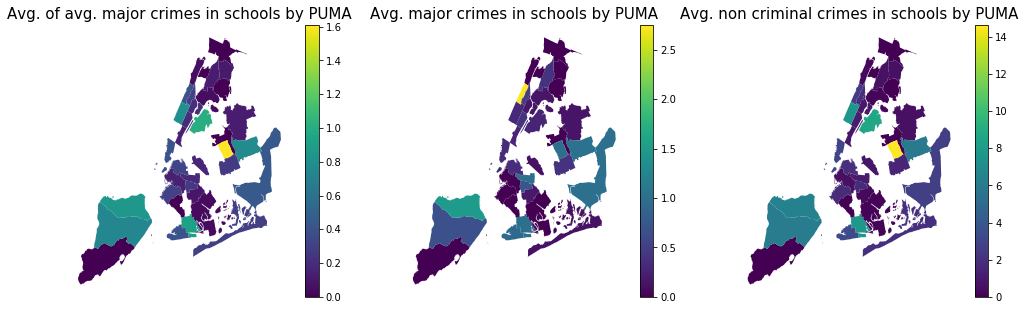

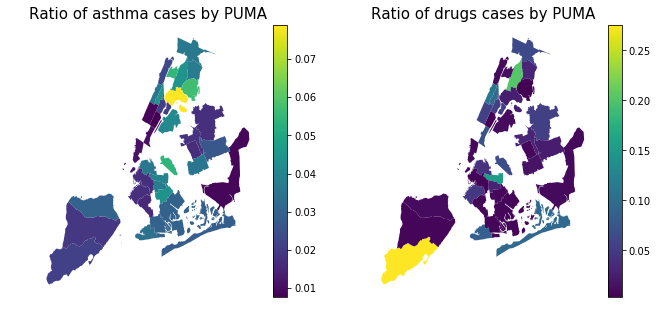

In [39]:
# initiate plot
plt.subplots(figsize=(17, 5))

# plot sat math by puma
ax = plt.subplot(1,3,1)
gdf_alldata.plot(column = 'SATmath', ax = ax, cmap = 'viridis', legend = True)
plt.title("Avg. maths SAT score by PUMA", fontsize = 15)
ax.set_axis_off()

# plot sat avg. by puma
ax1 = plt.subplot(1,3,2)
gdf_alldata.plot(column = 'SATall', ax = ax1, cmap = 'viridis', legend = True)
plt.title("Avg. overall SAT score by PUMA", fontsize = 15)
ax1.set_axis_off()
plt.show()

# initiate plot
plt.subplots(figsize=(17, 5))

# plot avg. of majorN by puma
ax1 = plt.subplot(1,3,1)
gdf_alldata.plot(column = 'AvgOfMajor N', ax = ax1, cmap = 'viridis', legend = \
True)
plt.title("Avg. of avg. major crimes in schools by PUMA", fontsize = 15)
ax1.set_axis_off()

# plot Major N by puma
ax = plt.subplot(1,3,2)
gdf_alldata.plot(column = 'Major N', ax = ax, cmap = 'viridis', legend = True)
plt.title("Avg. major crimes in schools by PUMA", fontsize = 15)
ax.set_axis_off()


# plot sat avg.of non criminal crimes by puma
ax2 = plt.subplot(1,3,3)
gdf_alldata.plot(column = 'AvgOfNoCrim N', ax = ax2, cmap = 'viridis', legend =\
 True)
plt.title("Avg. non criminal crimes in schools by PUMA", fontsize = 15)
ax2.set_axis_off()
plt.show()

# initiate plot
plt.subplots(figsize=(17, 5))

# plot asthma ratio by puma
ax = plt.subplot(1,3,1)
gdf_alldata.plot(column = 'asthmaRatio', ax = ax, cmap = 'viridis', legend = Tr\
ue)
plt.title("Ratio of asthma cases by PUMA", fontsize = 15)
ax.set_axis_off()

# plot drug ratio by puma
ax1 = plt.subplot(1,3,2)
gdf_alldata.plot(column = 'drugsRatio', ax = ax1, cmap = 'viridis', legend = Tr\
ue)
plt.title("Ratio of drugs cases by PUMA", fontsize = 15)
ax1.set_axis_off()
plt.show()


**Figures: Choropleths showing distribution of different features by PUMA.**

1. The above 7 choropleths shows the distribution of 2 SAT score features(SAT MAth And SAT Overall Average), 3 crime features( No.of major crimes in schools, Avg. no.of major crimes in schools and No. of non criminal crimes in schools) and 2 discharge features( Ratio of Asthma related cases and Ratio of Drugs related cases) by PUMA.

2. As can be seen in the top 2 choropleths, they look almost similar due to high corelation between SAT math score and SAT overall average scores. Middle Staten Isalnd peaks in both the scores and Bronx lacks the most.

3. In the middle row, again all the 3 choropleths showing crime statistics look similar with avg. of avg. major cimes in school and avg. of non criminal crimes in school peaking in Queens near jackson hieghts, and avg. of major crimes in school peaking in greenwich village. Lower Staten Island and bronx lacks in each of the 3 features.

4. The bottom 2 choropleths showing discharge statistics are fairly dissimilar to each other. Ratio of Asthma related cases peaks in bottom Bronx and ratio of Drugs related cases peaks in bottom staten island.

5. It is difficult to establish similarity across the rows of above choropleths, as each row shows choropleths of different type of features which are uncorrelated to each other.

### 8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature

As both the SAT features are highly colinear, we can choose to model any one of them, and the same model can be used to obtain other with almost similar accuracy. For the further analysis in section 8, we will try to model SATmath score.

Before modelling the data we will standardize all the features to make the scales similar and features comparable.

In [40]:
# Define a scale
scaler = StandardScaler()

# columns to scale
lis_columns = gdf_alldata.drop(['puma', 'shape_area', 'shape_leng', 'geometry'], axis=1).columns

# Standardize all features before moving to modelling
df_alldataScaled = pd.DataFrame(columns = lis_columns, data = scaler.fit_transf\
orm(gdf_alldata[lis_columns]))

In [41]:
# Define predictors
predictors = ['AvgOfOth N', 'AvgOfMajor N', 'AvgOfProp N', 'Prop N', 'Major N',\
'AvgOfNoCrim N', 'Oth N', 'NoCrim N', 'Vio N', 'AvgOfVio N']

# make the multivariate linear model
mod_linear1 = sm.OLS(df_alldataScaled['SATmath'], sm.add_constant(df_alldataSca\
led[predictors])).fit()

# Print the model summary
mod_linear1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     2.423
Date:                Mon, 17 Dec 2018   Prob (F-statistic):             0.0354
Time:                        21:18:50   Log-Likelihood:                -38.885
No. Observations:                  36   AIC:                             99.77
Df Residuals:                      25   BIC:                             117.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          7.563e-16      0.143   5.31e-15      1.000        -0.294     0.294
AvgOfOth N        1.3086      9.108      0.144      0.887       -17.450    20.067
AvgOfMajor N      0.1330      4.705      0.028      0.978        -9.557     9.823
AvgOfProp N      -1.1704      8.053     -0.145      0.886       -17.755    15.415
Prop N           -1.8829      1.389     -1.355      0.187        -4.744     0.978
Major N           0.8614      0.600      1.435      0.164        -0.375     2.097
AvgOfNoCrim N    -1.5646      2.365     -0.662      0.514        -6.434     3.305
Oth N             2.4117      1.893      1.274      0.214        -1.488     6.311
NoCrim N         -0.3200      0.543     -0.590      0.561        -1.438     0.798
Vio N            -1.1702      0.954     -1.226      0.232        -3.136     0.795
AvgOfVio N        2.0071      5.186      0.387      0.702        -8.674    12.688
==============================================================================
Omnibus:                        5.487   Durbin-Watson:                   1.429
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.230
Skew:                           0.812   Prob(JB):                        0.121
Kurtosis:                       3.425   Cond. No.                         265.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Model Results:**
1. From the summary of the above linear model, the R2 shows that crime related variables are able to describe 49% variation in the SAT Math Score.
2. None of the feature shows a strong performance in explaining the variation in SAT score as all the features have high p-value. The lowest p-value is for MajorN showing that at best, this can be a feature which can explain some variation in SAT score with significance.
3. The highest and lowest coefficient are for number of property crimes and number of other crimes as -1.88429 and 2.4117. The interpretation of these score means that for a unit deviation in number of property crimes there is a deviation in SAT math score equal to -1.88429 times the standard deviation of SAT math score. Similarly for a unit deviation in number of other crimes a deviation in SAT math score equal to 2.4117 times the standard deviation in SAT math score . But, as these 2 variable does not have a significant p-value scores, these realtions cannot be considered as statistically significant relations.


### 8.2 add drugs and asthma discharge data and create a new multilinear model

In [42]:
# extend predictors
predictors.append('asthmaRatio')
predictors.append('drugsRatio')

# make the multivariate linear model
mod_linear2 = sm.OLS(df_alldataScaled['SATmath'], sm.add_constant(df_alldataSca\
led[predictors])).fit()

# Print the model summary
mod_linear2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                SATmath   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     3.618
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00393
Time:                        21:18:54   Log-Likelihood:                -31.995
No. Observations:                  36   AIC:                             89.99
Df Residuals:                      23   BIC:                             110.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          7.563e-16      0.123   6.16e-15      1.000        -0.254     0.254
AvgOfOth N       -0.2940      7.975     -0.037      0.971       -16.792    16.204
AvgOfMajor N     -0.7432      4.163     -0.179      0.860        -9.355     7.869
AvgOfProp N       0.1558      7.042      0.022      0.983       -14.411    14.723
Prop N           -2.3991      1.220     -1.966      0.061        -4.923     0.125
Major N           1.0122      0.536      1.888      0.072        -0.097     2.121
AvgOfNoCrim N    -0.1781      2.100     -0.085      0.933        -4.523     4.167
Oth N             3.3767      1.672      2.019      0.055        -0.083     6.836
NoCrim N         -0.6128      0.478     -1.283      0.212        -1.601     0.375
Vio N            -1.2561      0.834     -1.507      0.146        -2.981     0.469
AvgOfVio N        1.4872      4.542      0.327      0.746        -7.910    10.884
asthmaRatio      -0.4343      0.136     -3.183      0.004        -0.717    -0.152
drugsRatio       -0.1143      0.137     -0.834      0.413        -0.398     0.169
==============================================================================
Omnibus:                        1.525   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.467   Jarque-Bera (JB):                1.236
Skew:                           0.255   Prob(JB):                        0.539
Kurtosis:                       2.249   Cond. No.                         272.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Model Results:**
1. The addition of asthmaRatio and drugRatio features in the prior linear model have improved the model's capability to explain the variation in SAT math score and has increased to 65%( R2 improved from 0.49 to 0.654).
2. The adjusted R2 has also improved from 0.29 to 0.47 reflecting that the increase in R2 is not just because of addition of degree of freedoms.
3. In the new model some features ( MajorN PropN OthN and asthmaRatio) shows a strong performance in explaining the variation in SAT score as all these features have p-value lower than 0.1. The lowest p-value is for asthmaRatio, showing it has strong relation with the SAT math feature.

### 9.1 Compare the linear models

To compare 2 linear models which have 1 nested under the other as in our case, we use likelihood ratio test to test whether restricted model is correct or not.

In our case, the restricted model is the first model created using only crime statistics, 'mod_linear1'.
And the complex model is the one created later using both crime and discharge statistics, 'mod_linear2.

To test the hypothesis that the complex model is better than the restricted we establish our Null and Alternate hypothesis as,

**H0: The restricted model is significantly better than the complex model.**

**H1: The complex model is significantly better than the restricted model.**

**alpha = 0.05**

If the likelihood ratio statistics is lower than the decided significance level, we will reject the Null hypothesis and accept alternate hypothesis.

In [43]:
# run lr test and store results
lr_results = mod_linear2.compare_lr_test(mod_linear1)

# print the results
print("The likelihood ratio is:", lr_results[0])
print("The p-value is:", lr_results[1])
print("The difference in degree of freedoms is:", lr_results[2])


The likelihood ratio is: 13.7801694761
The p-value is: 0.00101782758861
The difference in degree of freedoms is: 2.0


**Here, we see for the calculated likelihood ratio statistics we get p-value of 0.001 which is lower than our threshold of 0.05.
Thus, we reject the Null hypothesis that restricted model is better than the complex and accept the alternate hypothesis.**

**The linear model with both crime and health feature is better than the one with only crime features.**

### 10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features

Through the descriptive plots drawn earlier in this notebook, we know that the relation between the given features(crime and discharge data) and output( SAT Maths score) is not strictly linear. In fact, in many cases it is difficult to determine whether there is a relationship or not.

From literature we know for non-linear data, decision trees are known to work good and give better results. Thus, we will try to use random forest regressors to explain the variation in output feature(SAT score) using our input features(Crime and Health) and then, will use these models to understand the feature importance.

From the covariance matrix, we have witnessed many crime related features are correlated to each other.
Also, we know that the crime data comes from school level data which obviously have higher number of data points than the final PUMA level data.
Thus, we will use school level data to understand the importance of crime features in explaining the variation in SAT scores and choose the best features for preparing model ahead.

We need to scale the features in school data to make them of similar scale and comparable to each other.

In [44]:
# Define a scaler
scaler = StandardScaler()

# columns to scale
lis_columns = df_schools.drop(['DBN', 'Latitude', 'Longitude', 'geometry'], axi\
s=1).columns

# Standardize all features before moving to modelling
df_schoolsScaled = pd.DataFrame(columns = lis_columns, data = scaler.fit_transf\
orm(df_schools[lis_columns]))

**We split the data into train and test set in the ratio 2:1**

In [45]:
# define predictors
predictors = ['AvgOfOth N', 'AvgOfMajor N', 'AvgOfProp N', 'Prop N', 'Major N',\
'AvgOfNoCrim N', 'Oth N', 'NoCrim N', 'Vio N', 'AvgOfVio N']

# define output
output = ['SATmath']

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_schoolsScaled[predictors\
], df_schoolsScaled[output], test_size=0.33, random_state=42)

# define model
mod_rfr1 = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=123)

# fit model
mod_rfr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)

In [46]:
# print insample accuracy
print("The R2 of Random Forest model on training set is: ", mod_rfr1.scor\
e(X_train, y_train))

# print outsample accuracy
print("The R2 of Random Forest model on test set is: ", mod_rfr1.score(X_\
test, y_test))

The R2 of Random Forest model on training set is:  0.710540322993
The R2 of Random Forest model on test set is:  0.389595032949


**Our trained random forest model is able to give an R2 score of 0.71 on training set or in-sample R2, and an r2 of 0.389 on test set or out-of-sample R2. Thus, the model is able to explain 71% variation in train data output but only 38.9% variation in test data ouput.**

**There is a considerable difference between the insample and out of sample accuracy signalling towrads the overfitting of random forest model over the train data.**



### 10.2 measure the feature importance of the features in this model to select the 3 most predictive features

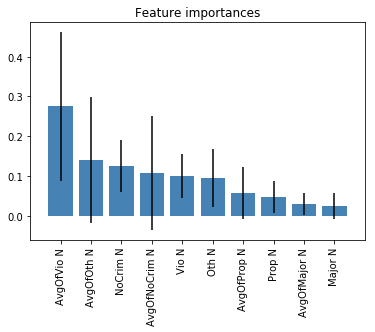

In [47]:
# Feature importance in random forest regressor model
featureImportancePlot(mod_rfr1, predictors)

**Figure: Plot of feature importance in random forest model.**
1. The above model shows the importance of all features used in modelling the random forest model on Schools data.
2. As we can see Avg. no. of Violent crime is a significant predictor in this model.
3. The other important predictors are Average no. of Other Crimes and No. of non criminal crimes. 

**As crime features have high collinearity, our objective here was to use random forest model to pick up the top 3 crime features.**

**Due to high collinearity we see a lot of feature getting very low importance.**

**We finally pick the top 3 features 'Avg no.of Violent Crimes, Avg. no.of Other Crimes and No.of Non Criminal crimes to be the features which will be used in the final Random Forest model.**

### 11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features

1. Here, we will train a random forest model on PUMA averaged data for all the features.
2. We have 36 observations.
3. We choose the top 3 crime features obtained in last section along with asthma ratio and drugs ratio as our predictors.
4. We split the data into train and test set in ratio 2:1.
5. All the features that will be used are already scaled from before.

In [48]:
# define predictors
predictors = [ 'AvgOfOth N','Vio N', 'AvgOfVio N','asthmaRatio', 'drugsRatio' ]

# define output
output = ['SATmath']

# train test split
X_train, X_test, y_train, y_test = train_test_split(df_alldataScaled[predictors\
], df_alldataScaled[output], test_size=0.33, random_state=42)

# define model
mod_rfr1 = RandomForestRegressor(random_state=102)

# fit model
mod_rfr1.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=102,
           verbose=0, warm_start=False)

### 11.2 Evaluate the performance of the model

To evaluate the model, we will use the R2 score on train and test sets. And then, will compare the results with linear model.

In [49]:
# print insample accuracy
print("The accuracy of Random Forest model on training set is: ", mod_rfr1.scor\
e(X_train, y_train))

# print outsample accuracy
print("The accuracy of Random Forest model on test set is: ", mod_rfr1.score(X_\
test, y_test))

The accuracy of Random Forest model on training set is:  0.93925338601
The accuracy of Random Forest model on test set is:  -0.430311731931


**1. The insample R2 of this final model is significantly high 0.93 thus, showing the model is able to explain a lot of variation in the output of train data.**

**2. The comparable linear model was able to explain only 65% variation in the output. So by train set R2 the RF model seems to be far superior than the linear model.**

**3. The out of sample R2 is -0.43. There is a schocking difference between the insample and out-of-sample R2. This negative R2 in addition to the large difference in in-sample and out-sample performance signals that the random forest model has overfitted the training data.**

**4. One possible reason for this overfitting is, our data is very small, we have only 36 observations. After splitting the data into train and test set, we are left with only 24 observations to train our model. Due to such a small data for training the random forest model is overfitting in this case.**

**5. Future-Work: Cross Validation strategies can be employed to avoid overfitting with such a small data set.**

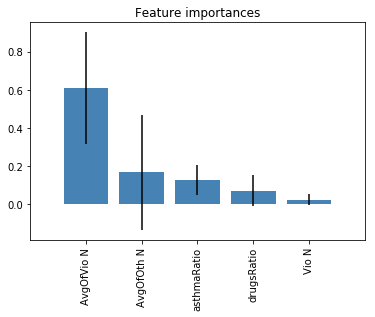

In [50]:
# Feature importance in random forest regressor model
featureImportancePlot(mod_rfr1, predictors)

**Figure: Plot of feature importance in final random forest model.**
1. The above model shows the importance of all features used in modelling the random forest model on PUMA aggregated data.
2. As we can see Avg. no. of Violent crime is a significant predictor in this model.
3. The other important predictors are Average no. of Other Crimes.

**Clearly again on the final dataset Average Number of Violent crime comes out to be the top feature.**

**If we compare this feature importance to the results of linear regression we find, asthma ratio was a significant feature in linear model whereas, it has very low importance in the random forest model.**

**Overfitting and collinearity of features can be a possible reason why asthma ratio cannot become a significant predictor here.**

## Discussion and Conclusion:

We started with the objective to model performance, measures through the SAT score, of NYC students as a function of exposure to crime, measured through reports of crimes in school, living conditions, measured through the incidence of respiratory and drug related issues in the area.

From the whole analysis we were able to gain some key insights as:

1. The SAT overall average score of a school is similar or related to the SAT maths score of the school.

2. The count of crime statistics are fairly related to each other and the avg. of these crime statistics are related amongst themselves. Thus, bringing forth the insight that if a school is prone to any particular type of crime then it is prone to all types of crime.

3. From linear model we get to know that the SAT score is significantly impacted by number of major crimes, number of property crimes and number of other crimes in school. Amongst these 3, property crimes have significant negative realtion with SAT scores. An increase in this results to decrease in SAT scores.

4. From linear model we also learn, asthma ratio holds significant negative relation with SAT score. Increase is asthma ratio leads to reduction in SAT score.

5. Given the small size of data it is not apt to use Random Forest in this case.